##### 氣象機器人 (1) - 雷達回波與地震資訊
透過之前的幾篇教學，應該已經熟悉一個 LINE BOT 的開發流程，接下來會銜接之前的範例，搭配氣象爬蟲的功能，開始實一個 LINE 的氣象機器人，\
這篇教學會先進行環境的設定，並串接雷達回波圖與地震資訊。

##### 建立 LINE BOT Channel 
參考「建立 LINE Channel」文章，進入 LINE Developer 的控制台，新增一個氣象機器人的 LINE Channel。

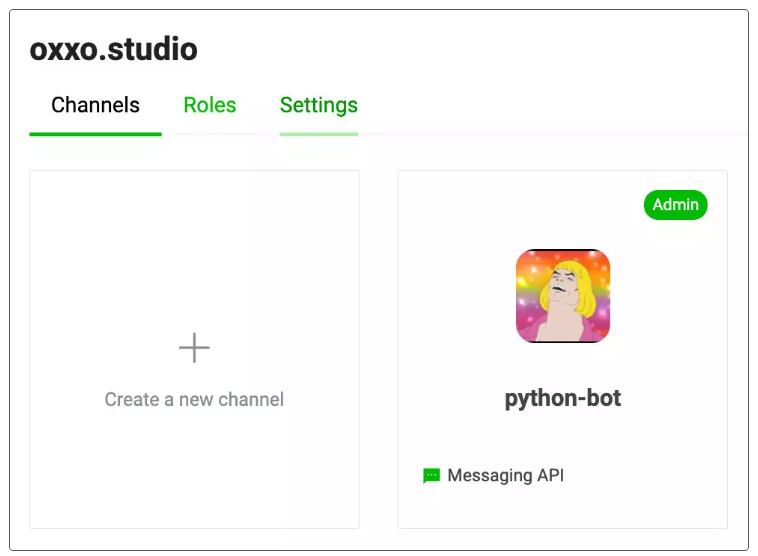

##### 串接 Colab + ngrok 測試用的 Webhook 
參考「使用 ngrok 服務」、「使用 Google Cloud Functions」和「建立並串接 Webhook」三篇教學，\
安裝 ngrok 和 line-bot-sdk，執行下方的程式碼產生 Webhook，回到 LINE Channel，\
確認 Webhook 可以正常運作 ( 驗證 Verify 後出現 success 表示 Webhook 沒有問題 )。

* 注意！如果使用 ngrok 搭配 Colab 做開發測試，每次執行後產生的網址都不同，需要重複更新 LINE 的 Webhook。

In [ ]:
from flask import Flask, request
# from pyngrok import ngrok   # Colab 環境需要，本機環境不需要

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage, StickerSendMessage, ImageSendMessage, LocationSendMessage

import json
app = Flask(__name__)

# Colab 環境需要下面這三行，本機環境不需要
# port = "5000"
# public_url = ngrok.connect(port).public_url
# print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\" ")

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                 # 取得收到的訊息內容
    try:
        line_bot_api = LineBotApi('你的 Access Token')     # 確認 token 是否正確
        handler = WebhookHandler('你的 Channel Serect')    # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']   # 加入回傳的 headers
        handler.handle(body, signature)      # 綁定訊息回傳的相關資訊
        json_data = json.loads(body)         # 轉換內容為 json 格式
        print(json_data)                     # 印出內容
    except:
        print(body)             # 如果發生錯誤，印出收到的內容
    return 'OK'                 # 驗證 Webhook 使用，不能省略
if __name__ == "__main__":
    app.run()

Webhook 完成後，回到 LINE 將這個氣象機器人加入好友，並傳送訊息，在 Colab 裡就會出現傳送的訊息內容。

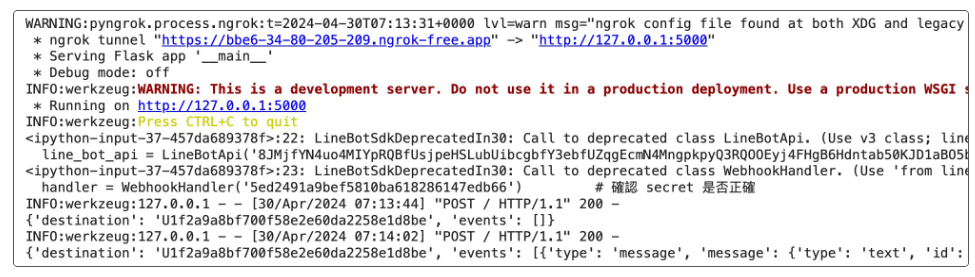

##### 串接雷達回波圖 
參考「[LINE Notify 傳送雷達回波圖](https://steam.oxxostudio.tw/category/python/spider/radar.html)」文章，\
由於雷達回波圖的圖片網址是固定的，所以只要修改原本的程式碼，當收到的訊息為「雷達回波圖」或「雷達回波」時，\
使用 reply message 的方法回傳圖片訊息即可 ( 圖片後方記得加上時間戳記，避免因為緩存的關係都顯示相同的圖片 )

雷達回波圖片網址：https://cwaopendata.s3.ap-northeast-1.amazonaws.com/Observation/O-A0058-001.png

下方的程式碼修改的重點如下：
* 將 access token 和 channel_secret 獨立為變數。
* 使用 if 判斷訊息是否出現「雷達回波圖」或「雷達回波」。
* 使用標準函式庫 time 來增加圖片的時間戳記。

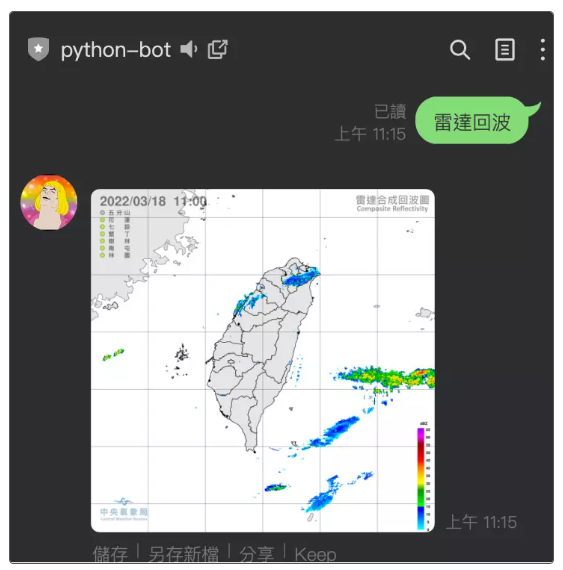

In [ ]:
from flask import Flask, request
# from pyngrok import ngrok   # Colab 環境需要，本機環境不需要
import time

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage, StickerSendMessage, ImageSendMessage, LocationSendMessage

import json
app = Flask(__name__)

# Colab 環境需要下面這三行，本機環境不需要
# port = "5000"
# public_url = ngrok.connect(port).public_url
# print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\" ")

access_token = 'l7Ri22mpL431SIYQKAGs0iMJz1X5c9weXz'
channel_secret = 'f2506993'

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                 # 取得收到的訊息內容
    try:
        line_bot_api = LineBotApi(access_token)           # 確認 token 是否正確
        handler = WebhookHandler(channel_secret)          # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']   # 加入回傳的 headers
        handler.handle(body, signature)      # 綁定訊息回傳的相關資訊
        json_data = json.loads(body)         # 轉換內容為 json 格式
        reply_token = json_data['events'][0]['replyToken']    # 取得回傳訊息的 Token ( reply message 使用 )
        user_id = json_data['events'][0]['source']['userId']  # 取得使用者 ID ( push message 使用 )
        print(json_data)                                      # 印出內容
        type = json_data['events'][0]['message']['type']
        if type == 'text':
            text = json_data['events'][0]['message']['text']
            if text == '雷達回波圖' or text == '雷達回波':
                line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))   # 一開始先發送訊息
                img_url = f'https://cwaopendata.s3.ap-northeast-1.amazonaws.com/Observation/O-A0058-001.png?{time.time_ns()}'
                img_message = ImageSendMessage(original_content_url=img_url, preview_image_url=img_url)
                line_bot_api.reply_message(reply_token, img_message)  # 回傳訊息
            else:          
                text_message = TextSendMessage(text=text)
                line_bot_api.reply_message(reply_token,text_message)
    except Exception as e:
        print(e)                # 發生錯誤就印出完整錯誤內容
    return 'OK'                 # 驗證 Webhook 使用，不能省略
if __name__ == "__main__":
    app.run()

##### 串接地震資訊 
首先執行下方函式，觀察是否能夠正確抓到地震資訊，由於氣象局提供的地震資訊有兩組，因此兩組都要抓取資料，再透過判斷時間的先後順序，取出最新的地震資料。

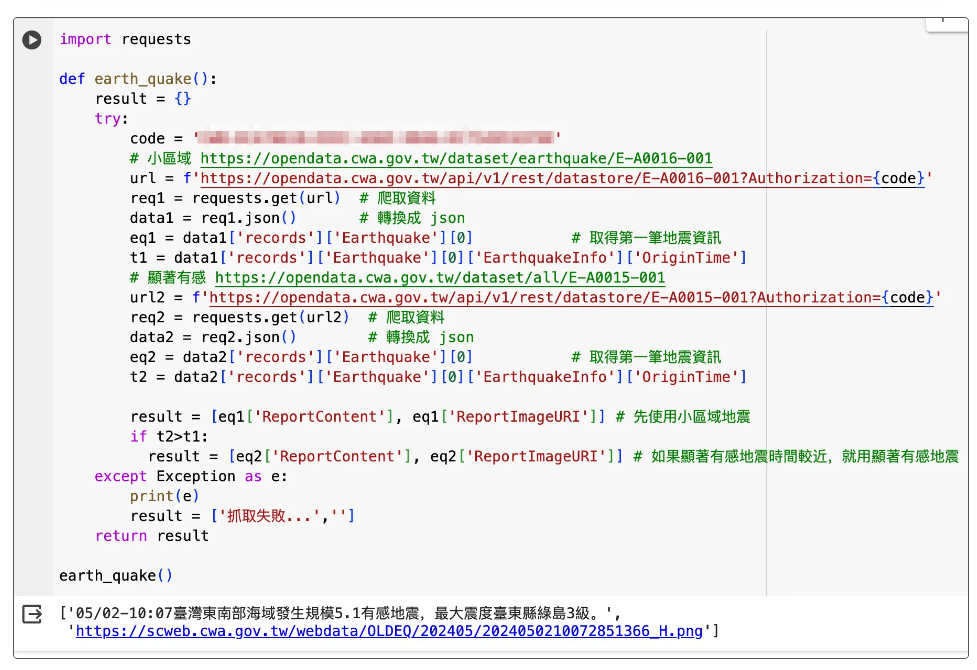

In [ ]:
import requests

def earth_quake():
    result = []
    try:
        code = '你的氣象 token'
        # 小區域 https://opendata.cwa.gov.tw/dataset/earthquake/E-A0016-001
        url = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/E-A0016-001?Authorization={code}'
        req1 = requests.get(url)  # 爬取資料
        data1 = req1.json()       # 轉換成 json
        eq1 = data1['records']['Earthquake'][0]           # 取得第一筆地震資訊
        t1 = data1['records']['Earthquake'][0]['EarthquakeInfo']['OriginTime']
        # 顯著有感 https://opendata.cwa.gov.tw/dataset/all/E-A0015-001
        url2 = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/E-A0015-001?Authorization={code}'
        req2 = requests.get(url2)  # 爬取資料
        data2 = req2.json()        # 轉換成 json
        eq2 = data2['records']['Earthquake'][0]           # 取得第一筆地震資訊
        t2 = data2['records']['Earthquake'][0]['EarthquakeInfo']['OriginTime']
        
        result = [eq1['ReportContent'], eq1['ReportImageURI']] # 先使用小區域地震
        if t2>t1:
          result = [eq2['ReportContent'], eq2['ReportImageURI']] # 如果顯著有感地震時間較近，就用顯著有感地震
    except Exception as e:
        print(e)
        result = ['抓取失敗...','']
    return result

earth_quake()

將爬取地震資訊的程式和 LINE BOT 的程式組合，就能透過發送「地震」兩個字來觸發抓取地震資訊的函式。

In [4]:
from flask import Flask, request
# from pyngrok import ngrok   # Colab 環境需要，本機環境不需要
import json, time, requests

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage, StickerSendMessage, ImageSendMessage, LocationSendMessage

app = Flask(__name__)

# Colab 環境需要下面這三行，本機環境不需要
# port = "5000"
# public_url = ngrok.connect(port).public_url
# print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\" ")

def earth_quake():
    result = []
    code = 'eEztR83E/Vg1RnJBC/3y7vVJMgaLb54zLrf'
    try:
        # 小區域 https://opendata.cwa.gov.tw/dataset/earthquake/E-A0016-001
        url = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/E-A0016-001?Authorization={code}'
        req1 = requests.get(url)  # 爬取資料
        data1 = req1.json()       # 轉換成 json
        eq1 = data1['records']['Earthquake'][0]           # 取得第一筆地震資訊
        t1 = data1['records']['Earthquake'][0]['EarthquakeInfo']['OriginTime']
        # 顯著有感 https://opendata.cwa.gov.tw/dataset/all/E-A0015-001
        url2 = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/E-A0015-001?Authorization={code}'
        req2 = requests.get(url2)  # 爬取資料
        data2 = req2.json()        # 轉換成 json
        eq2 = data2['records']['Earthquake'][0]           # 取得第一筆地震資訊
        t2 = data2['records']['Earthquake'][0]['EarthquakeInfo']['OriginTime']
        
        result = [eq1['ReportContent'], eq1['ReportImageURI']] # 先使用小區域地震
        if t2>t1:
          result = [eq2['ReportContent'], eq2['ReportImageURI']] # 如果顯著有感地震時間較近，就用顯著有感地震
    except Exception as e:
        print(e)
        result = ['抓取失敗...','']
    return result

access_token = 'eEztR83E/Vg1RnJBC/3y7vVJMgaLb54zLrfWbE'
channel_secret = 'c8356d8e9'

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        line_bot_api = LineBotApi(access_token)     # 確認 token 是否正確
        handler = WebhookHandler(channel_secret)    # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']             # 加入回傳的 headers
        handler.handle(body, signature)      # 綁定訊息回傳的相關資訊
        json_data = json.loads(body)         # 轉換內容為 json 格式
        reply_token = json_data['events'][0]['replyToken']    # 取得回傳訊息的 Token ( reply message 使用 )
        user_id = json_data['events'][0]['source']['userId']  # 取得使用者 ID ( push message 使用 )
        print(json_data)                                      # 印出內容
        type = json_data['events'][0]['message']['type']
        if type == 'text':
            text = json_data['events'][0]['message']['text']
            if text == '雷達回波圖' or text == '雷達回波':
                line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
                img_url = f'https://cwaopendata.s3.ap-northeast-1.amazonaws.com/Observation/O-A0058-001.png?{time.time_ns()}'
                img_message = ImageSendMessage(original_content_url=img_url, preview_image_url=img_url)
                line_bot_api.reply_message(reply_token,img_message)
            elif text == '地震':
                line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
                reply = earth_quake()   # 執行函式，讀取數值
                text_message = TextSendMessage(text=reply[0])        # 取得文字內容
                line_bot_api.reply_message(reply_token,text_message) # 傳送文字
                line_bot_api.push_message(user_id, ImageSendMessage(original_content_url=reply[1], preview_image_url=reply[1])) # 傳送圖片
            else:          
                text_message = TextSendMessage(text=text)
                line_bot_api.reply_message(reply_token,text_message)
    except Exception as e:
        print(e)                # 發生錯誤就印出完整錯誤內容
    return 'OK'                 # 驗證 Webhook 使用，不能省略

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


完成後重新執行，設定新的 ngrok 網址為 Webhook，驗證成功後，在 LINE 裡面輸入「地震」，就會收到最新一筆的地震資料和地震圖。

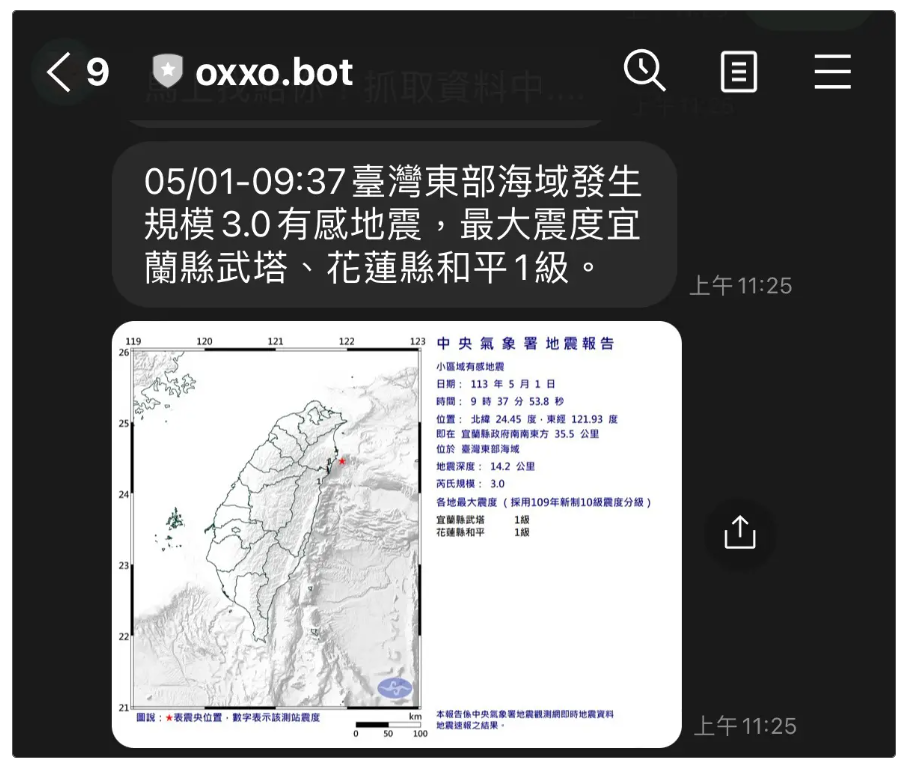

##### 小結 
氣象機器人的功能不只如此，接下來的幾篇會繼續介紹如何串接即時氣象、天氣預報和空氣品質資訊。